# 1. Import các thư viện hỗ trợ lập trình

In [1]:
from surprise import SVD, Dataset, Reader, SVDpp, NMF, NormalPredictor, KNNBasic
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from collections import defaultdict
from surprise import accuracy
from surprise import dump
import numpy as np
import pandas as pd
import csv

# 2. Load data and EDA

In [2]:
origin_data = pd.read_csv('../Data/final_rating_not_spare.csv', usecols=['customer_id', 'product_id', 'stars'])

In [3]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20849 entries, 0 to 20848
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   product_id   20849 non-null  int64
 1   customer_id  20849 non-null  int64
 2   stars        20849 non-null  int64
dtypes: int64(3)
memory usage: 488.8 KB


In [4]:
origin_data.head()

,product_id,customer_id,stars
0,9672,53270,5
1,9672,91213,4
2,3038,56289,5
3,3038,88524,5
4,3038,72126,5


### ! Surprise library format data theo các cột: User, Item, Rating. Do đó, sử dụng file format

In [5]:
all_rating = pd.read_csv('../Data/all_rating.csv')

In [6]:
format_data = pd.read_csv('../Data/final_rating_not_spare_format.csv')
format_data.head()

,item,user,rating
0,9672,53270,5
1,9672,91213,4
2,3038,56289,5
3,3038,88524,5
4,3038,72126,5


### EDA phân bố đánh giá

In [7]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = format_data['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / format_data.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Biểu đồ phân phối của {} ratings'.format(format_data.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Số lượng'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [8]:
data = format_data.groupby('item')['rating'].count().clip(upper=40)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 10,
                                  end = 200,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Biểu đồ phân phối số sao đánh giá mỗi sản phẩm (Xét tối đa là 200 đánh giá)',
                   xaxis = dict(title = 'Số lượt đánh giá'),
                   yaxis = dict(title = 'Số lượng sách'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [9]:
format_data.groupby('item')['rating'].count().reset_index().sort_values('rating', ascending=False)[10:]

,item,rating
4761,9161,26
5053,9781,26
734,1420,25
4365,8370,25
4906,9455,25
...,...,...
1347,2539,1
745,1439,1
3941,7610,1
1343,2535,1


In [10]:
data = format_data.groupby('user')['rating'].count().clip(upper=40)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Phân phối đánh giá theo người dùng (xét tối đa 40 đánh giá)',
                   xaxis = dict(title = 'Số lượt đánh giá của mỗi người'),
                   yaxis = dict(title = 'Số lượng người dùng'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [11]:
format_data.groupby('user')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,user,rating
514,48036,148
684,63996,84
416,36454,68
499,45589,65
1335,127590,62
981,90422,61
1054,98864,58
251,19931,57
394,33591,56
356,30255,55


# 3. Surprise - model selection

In [12]:
file_path = '../Data/final_rating_not_spare_format.csv'
reader = Reader(line_format='item user rating', sep=',', rating_scale = (1,5), skip_lines=1)

data = Dataset.load_from_file(file_path, reader=reader)

In [13]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [14]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.579832,0.336416,1.404071,0.092673
KNNBasic,0.751567,0.406697,0.093339,0.163264
NormalPredictor,0.834492,0.542489,0.033078,0.072917
NMF,0.851787,0.652043,2.187002,0.072004


## Tunining algorithm parameters with to find the best parameters for the algorithm.

Default values for SVD:
- n_factors - 100
- n_epochs - 20
- lr_all – 0.005
- reg_all – 0.02


In [15]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, return_train_measures=True)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']



0.5680282385625571
{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.1}


## Training and Testing

In [16]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=43)
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  1382 

Number of items:  4881 



In [17]:
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.5322


0.5321553952639398

### Let's check how good or bad our predictions are:

The following function will create a pandas data frame which will consist of these columns:

**UID**: user-id

**iid**: item id

**Rui**: the rating given by the user

**est**: rating estimated by the model

**Iu**: No of items rated by the user

**UI**: number of users that have rated this item

**err**: abs difference between predicted rating and the actual rating.


In [18]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [19]:
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,125199,1837,5.0,4.608253,{'was_impossible': False},10,15,0.391747
1,65488,6878,5.0,4.675998,{'was_impossible': False},13,5,0.324002
2,118840,2490,5.0,4.847784,{'was_impossible': False},15,0,0.152216
3,115016,7744,4.0,4.770813,{'was_impossible': False},18,4,0.770813
4,20495,1866,5.0,4.557089,{'was_impossible': False},22,4,0.442911


## Let's see the 10 best and worst predictions our model made

In [20]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [21]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
609,119574,4693,5.0,5.0,{'was_impossible': False},8,4,0.0
1531,92673,7393,5.0,5.0,{'was_impossible': False},34,8,0.0
1529,65887,8169,5.0,5.0,{'was_impossible': False},13,5,0.0
3982,82888,8346,5.0,5.0,{'was_impossible': False},34,19,0.0
3980,52494,9204,5.0,5.0,{'was_impossible': False},36,5,0.0
3320,68956,598,5.0,5.0,{'was_impossible': False},5,15,0.0
683,110700,8679,5.0,5.0,{'was_impossible': False},9,4,0.0
2184,55338,3534,5.0,5.0,{'was_impossible': False},9,12,0.0
3979,18620,9793,5.0,5.0,{'was_impossible': False},38,2,0.0
2714,70182,2187,5.0,5.0,{'was_impossible': False},18,3,0.0


In [22]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
523,7432,4317,1.0,4.566855,{'was_impossible': False},11,1,3.566855
1903,98864,1381,5.0,1.348707,{'was_impossible': False},48,9,3.651293
824,23598,5248,1.0,4.703845,{'was_impossible': False},8,7,3.703845
1673,115584,6328,1.0,4.720897,{'was_impossible': False},15,7,3.720897
3456,65154,9359,1.0,4.752760,{'was_impossible': False},13,5,3.752760
2700,108690,6296,1.0,4.856180,{'was_impossible': False},20,4,3.856180
3421,32896,3085,1.0,4.929213,{'was_impossible': False},35,1,3.929213
2910,46801,1185,1.0,4.934567,{'was_impossible': False},6,1,3.934567
1807,60028,2329,1.0,4.957366,{'was_impossible': False},29,0,3.957366
4083,52494,1622,1.0,5.000000,{'was_impossible': False},36,6,4.000000


In [23]:
format_data.loc[format_data['item'] == 23598]['rating']

Series([], Name: rating, dtype: int64)

In [24]:
temp = format_data.loc[format_data['item'] == 23598]['rating']

# Create trace
trace = go.Histogram(x = temp.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 5, size=.3))
 # Create layout
layout = go.Layout(title = 'Number of ratings item 3996 has received',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# 4. k recommendations

Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.


### Conversion to binary

To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.

**Relevant**: True Rating > = 3.5

**Irrelevant**: True Rating < 3.5

## Definition of Precision and Recall

Precision: It tries to answer "What proportion of positive identifications was actually correct?" i.e True positive / (True positive+False Positive) in RecSys we can say (# of recommended items @k that are relevant) / (# of recommended items @k)

Recall: It tries to answer "What proportion of actual positives were identified correctly?" i.e True positive / (True Positive+False Negative) in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)


While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

In some circumstances, we might know that we need to maximize either recall or precision at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use F1 score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

f1 score = 2 (precision recall) / (precision + recall)


In [25]:
#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,4170,0,0,0,1.000000,1.000000,1.000000
1,0.5,4170,0,0,0,1.000000,1.000000,1.000000
2,1.0,4170,0,0,0,1.000000,1.000000,1.000000
3,1.5,4136,31,2,1,0.992561,0.999758,0.996146
4,2.0,4135,25,8,2,0.993990,0.999517,0.996746
5,2.5,4097,61,10,2,0.985329,0.999512,0.992370
6,3.0,4096,58,13,3,0.986038,0.999268,0.992609
7,3.5,3963,179,23,5,0.956784,0.998740,0.977312
8,4.0,3898,141,61,70,0.965090,0.982359,0.973648
9,4.5,3142,323,400,305,0.906782,0.911517,0.909144


In [26]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls

In [27]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=4.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    f1 = 2 * (prec * rec) / (prec + rec)  

    results.append({'K': i, 'Precision': prec, 'Recall': rec, 'F1': f1})
    

results

[{'K': 2,
  'Precision': 0.9065384615384615,
  'Recall': 0.663026459932329,
  'F1': 0.7658924823359485},
 {'K': 3,
  'Precision': 0.9046153846153843,
  'Recall': 0.780343871827678,
  'F1': 0.8378969034964402},
 {'K': 4,
  'Precision': 0.904487179487179,
  'Recall': 0.8363746536863942,
  'F1': 0.8690984397403889},
 {'K': 5,
  'Precision': 0.9044102564102557,
  'Recall': 0.8609609911006673,
  'F1': 0.8821509377344321},
 {'K': 6,
  'Precision': 0.9043333333333328,
  'Recall': 0.8711813333989445,
  'F1': 0.8874478301217436},
 {'K': 7,
  'Precision': 0.9041318681318675,
  'Recall': 0.876437667483214,
  'F1': 0.890069396058719},
 {'K': 8,
  'Precision': 0.9042280219780213,
  'Recall': 0.8795770907005723,
  'F1': 0.8917322270784022},
 {'K': 9,
  'Precision': 0.9041852869352863,
  'Recall': 0.8812983487497656,
  'F1': 0.8925951315528735},
 {'K': 10,
  'Precision': 0.9041767399267393,
  'Recall': 0.8823007423300945,
  'F1': 0.8931048017769274}]

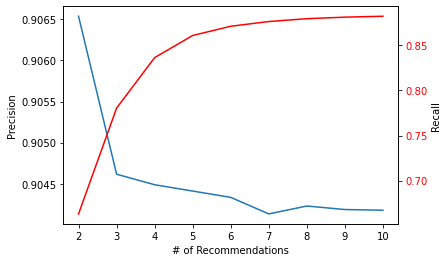

In [28]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

# 5. Time to recommend some movies to users

In [29]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)
# Predict ratings fo8r all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

Function get all predicts sorted

In [30]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [31]:
all_pred = get_all_predictions(predictions)

In [32]:
#To get top 10 recommendation
n = 10

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]



In [33]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

In [34]:
tmp_transpose.index

Index(['53270', '91213', '56289', '88524', '72126', '131996', '9077', '113186',
       '34988', '119325',
       ...
       '100672', '122601', '11599', '81178', '88664', '1319', '119382',
       '83103', '75278', '39283'],
      dtype='object', length=1382)

In [35]:
tmp_transpose.head()

,0,1,2,3,4,5,6,7,8,9
53270,"(3038, 5)","(1287, 5)","(749, 5)","(4032, 5)","(11, 5)","(1031, 5)","(4529, 5)","(538, 5)","(2831, 5)","(6601, 5)"
91213,"(8257, 5)","(9002, 5)","(1910, 5)","(3428, 5)","(1668, 5)","(692, 5)","(252, 5)","(5837, 5)","(1286, 4.990840040356788)","(8640, 4.984585248812934)"
56289,"(1287, 5)","(770, 5)","(1769, 5)","(243, 5)","(8257, 5)","(5391, 5)","(8485, 5)","(5964, 5)","(6407, 5)","(4426, 5)"
88524,"(1287, 5)","(892, 5)","(1769, 5)","(243, 5)","(748, 5)","(2826, 5)","(386, 5)","(8257, 5)","(5368, 5)","(9021, 5)"
72126,"(9940, 5)","(1287, 5)","(749, 5)","(52, 5)","(4032, 5)","(7871, 5)","(4529, 5)","(737, 5)","(172, 5)","(5879, 5)"


In [56]:
tmp_transpose.loc['72126']

0    (9940, 5)
1    (1287, 5)
2     (749, 5)
3      (52, 5)
4    (4032, 5)
5    (7871, 5)
6    (4529, 5)
7     (737, 5)
8     (172, 5)
9    (5879, 5)
Name: 72126, dtype: object

Now we have a dataframe which consits of top 4 movies recommended to every user.
Let's try one example and find recommendations for user 67


In [37]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [61]:
user_id='72126'
results = get_predictions(user_id)
results

0    (9940, 5)
1    (1287, 5)
2     (749, 5)
3      (52, 5)
4    (4032, 5)
5    (7871, 5)
6    (4529, 5)
7     (737, 5)
8     (172, 5)
9    (5879, 5)
Name: 72126, dtype: object

Above matrix is showing top "4" recommendations for user 67. (Movie-id, Predicted-Rating).
But we just need the movies not the ratings, so let's extract the movie id's from the result.

In [39]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids

['3038', '9940', '1287', '749', '4032', '7871', '4695', '1031', '6461', '538']

## Save to database

In [89]:
all_customer = format_data['user'].unique()

In [90]:
all_customer[:5]

array([53270, 91213, 56289, 88524, 72126], dtype=int64)

In [66]:
items = pd.read_csv('../Data/final_all_clean_books.csv')

In [78]:
items.loc[items['new_id']==53270]['id']

Series([], Name: id, dtype: int64)

In [113]:
data = []
count = 0
for id in list(all_customer):
    results = get_predictions(str(id))
    recommended_movie_ids=[]
    for x in range(0, 10):
        rs_id = items.loc[items['new_id']==int(results[x][0])]['id'].values[0]
        recommended_movie_ids.append(rs_id)
    data.append([id, recommended_movie_ids])
data[0]

[53270,
 [3071851,
  568145,
  474168,
  7959221,
  339327,
  532318,
  10697068,
  439874,
  2612575,
  32080645]]

In [114]:
df = pd.DataFrame(data)

In [115]:
df.head()

,0,1
0,53270,"[3071851, 568145, 474168, 7959221, 339327, 532..."
1,91213,"[49659437, 54809933, 970220, 4483791, 777253, ..."
2,56289,"[568145, 475828, 859057, 393554, 49659437, 152..."
3,88524,"[568145, 500769, 859057, 393554, 474165, 26125..."
4,72126,"[59235430, 568145, 474168, 343300, 7959221, 47..."


In [116]:
df.to_csv('../Data/svd-rs.csv', index=False)

In [102]:
a = data[0][1]

In [104]:
items.loc[items['id'].isin(a)]['name'].values

array(['Sách Lật Tương Tác Song Ngữ 0-3 Tuổi: Mông Ai Đây?',
       'Góc Sân Và Khoảng Trời - Hạt Gạo Làng Ta',
       'Truyện Cổ Andersen (Bìa Mềm)',
       'Chỉ Số Cảm Xúc EQ - Phát Triển Chỉ Số Cảm Xúc- Miếng Dán Thần Kì - 3 Đến 4 Tuổi (Tái Bản)',
       'Sách Tương Tác - Sách Chuyển Động - Busy - Holiday - Kỳ Nghỉ',
       'Pettson & Findus - Chuyến Dã Ngoại Li Kì',
       'Tập Tô Màu Mẫu Giáo - Chủ Đề Giao Thông',
       'Bộ Túi 2 - Bộ Sách Giáo Dục Sớm Dành Cho Trẻ Em Từ 2-8 Tuổi - Rèn Luyện Kỹ Năng Sống, Giúp Trẻ Biết Tự Lập, Biết Yêu Thương, Chia Sẻ',
       '10 Vạn Câu Hỏi Vì Sao - Khám Phá Thế Giới Thực Vật (Tái Bản 2018)',
       'Bộ Truyện Giáo Dục Giới Tính Cho Trẻ Nhỏ - Tại Sao Con Là Con Trai?'],
      dtype=object)

In [106]:
list_rated = list(format_data.loc[format_data['user']==53270]['item'].values)

In [107]:
items.loc[items['new_id'].isin(list_rated)]['name'].values

array(['Những Câu Chuyện Sưởi Ấm Tâm Hồn: Ngôi Nhà Trong Cỏ',
       'Đồng hành cùng con học Tiếng Anh', 'Tiệm Sách Cơn Mưa',
       'Anne Tóc Đỏ Làng Avonlea (Tái Bản 2019)', 'Thành Ngữ Bằng Tranh',
       'Thực Hành Giáo Dục Nhân Cách (Giúp Trẻ Trưởng Thành Hạnh Phúc Và Vững Vàng)',
       'Hachiko - Chú Chó Đợi Chờ (Bìa Mềm) (Tái Bản 2019)',
       'Siêu Nhí Hỏi Nhà Khoa Học Trả Lời - 100 Bí Ẩn Mọi Đứa Trẻ Đều Muốn Hỏi Một Nhà Khoa Học',
       'Ehon Kỹ Năng Sống: Em Biết Quan Tâm, Chia Sẻ',
       'Chuyện Phiêu Lưu Của Mít Đặc Và Các Bạn ( Bìa Cứng)(Tái Bản 2019)',
       'Cuộc Phiêu Lưu Của Quả Lê Khổng Lồ (Tái Bản 2019)',
       '80++ Hoạt Động Thử Tài IQ, Rèn Luyện Tư Duy',
       'Quiz! Khoa Học Kì Thú: Những Cái Nhất Và Đầu Tiên Trên Thế Giới (Tái Bản 2020)',
       'Quiz! Khoa Học Kì Thú: Cơ Thể Con Người (Tái Bản 2020)',
       'Quiz! Khoa Học Kì Thú: Thế Giới Huyền Bí (Tái Bản 2020)',
       'Quiz! Khoa Học Kì Thú: Vũ Trụ (Tái Bản 2020)',
       'Quiz! Khoa Học Kì Thú: Phát

In [80]:
first_ratings = pd.read_csv('../Data/all_rating.csv')
first_ratings.groupby('customer_id')['stars'].count().reset_index().sort_values('stars', ascending=False)[:10]

,customer_id,stars
52231,5582356,163
69896,7031251,97
124448,15701232,78
39520,1895509,73
49541,5399042,70
108075,12631514,65
98819,11202148,64
139641,17612596,63
21574,810770,59
57168,5962045,59


In [81]:
first_ratings.groupby('product_id')['stars'].count().reset_index().sort_values('stars', ascending=False)[:10]

,product_id,stars
0,181893,200
4599,11232442,200
2010,970950,200
3534,5449561,200
2014,974014,200
7771,49365848,200
2028,982037,200
2030,984938,200
7749,49249526,200
3535,5449569,200


In [144]:
items['new_id'].max()

10329

# ------------------------------
## Old code

In [ ]:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [8]:
trainsetfull = data.build_full_trainset()
print('Number of users: ', trainsetfull.n_users, '\n')
print('Number of items: ', trainsetfull.n_items, '\n')

Number of users:  5289 

Number of items:  1382 



In [10]:
param_grid_2 = {'n_factors':[5, 10,20],'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs_model_2 = GridSearchCV(SVD,param_grid=param_grid_2, n_jobs = -1, joblib_verbose=5)
gs_model_2.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.4min finished


In [11]:
gs_model_2.best_params

{'rmse': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4},
 'mae': {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}}

In [12]:
svd2 = SVD(n_factors=20, n_epochs=20, lr_all=0.005, reg_all=0.6)
svd2.fit(trainset)
predictions = svd2.test(testset)
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))
print(accuracy.fcp(predictions))

RMSE: 0.5450
0.5450495272216493
MAE:  0.3287
0.32872229368379235
FCP:  0.5888
0.5887594936708861


In [13]:
param_grid_3 = {'n_factors':[20],'n_epochs': [20], 'lr_all': [0.004, 0.005, 0.006],
              'reg_all': [0.5, 0.6, 0.7]}

gs_model_3 = GridSearchCV(SVD,param_grid=param_grid_3,n_jobs = -1,joblib_verbose=5)
gs_model_3.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   39.6s finished


In [14]:
gs_model_3.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.5},
 'mae': {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.5}}

In [15]:
param_grid_4 = {'n_factors':[20, 30],'n_epochs': [20], 'lr_all': [0.006, 0.01, 0.015],
              'reg_all': [0.7, 1, 1.5]}

gs_model_4 = GridSearchCV(SVD,param_grid=param_grid_4,n_jobs = -1,joblib_verbose=5)
gs_model_4.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


In [16]:
gs_model_4.best_params

{'rmse': {'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.7},
 'mae': {'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.015, 'reg_all': 0.7}}

In [17]:
gs_model_4.best_score

{'rmse': 0.5763102673859464, 'mae': 0.33417214310816595}

In [18]:
param_grid_5 = {'n_factors':[30, 40, 50],'n_epochs': [20], 'lr_all': [0.006],
              'reg_all': [0.7]}

gs_model_5 = GridSearchCV(SVD,param_grid=param_grid_5,n_jobs = -1,joblib_verbose=5)
gs_model_5.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   13.4s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.7s finished


In [19]:
gs_model_5.best_params


{'rmse': {'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.7},
 'mae': {'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.006, 'reg_all': 0.7}}

In [20]:
gs_model_5.best_score


{'rmse': 0.5781285655026138, 'mae': 0.3428240357209737}

In [21]:
chosen_SVD = SVD(n_factors= 50, n_epochs=20, lr_all=0.006, reg_all=0.7)
chosen_SVD.fit(trainset)
predictions = chosen_SVD.test(testset)
accuracy.rmse(predictions)

RMSE: 0.5464


0.5463804052751202

# SVD++

In [22]:
chosen_SVDpp = SVDpp()
chosen_SVDpp.fit(trainset)
predictions = chosen_SVDpp.test(testset)
accuracy.rmse(predictions)

RMSE: 0.5344


0.5344483344424271

In [23]:
param_grid_6 = {'n_factors':[20, 30],'n_epochs': [20], 'lr_all': [0.006, 0.01],
              'reg_all': [0.7, 1]}

gs_model_6 = GridSearchCV(SVDpp,param_grid=param_grid_6,n_jobs = -1,joblib_verbose=5)
gs_model_6.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.2min finished


In [24]:
from surprise import SlopeOne, CoClustering

In [25]:
algo = SlopeOne()
results = cross_validate(algo, data, measures = ['RMSE'], return_train_measures=True)
results

{'test_rmse': array([0.70038591, 0.72105193, 0.72781083, 0.71335018, 0.71941643]),
 'train_rmse': array([0.11395113, 0.11130666, 0.11365267, 0.11728612, 0.11848615]),
 'fit_time': (0.2700638771057129,
  0.23703742027282715,
  0.462996244430542,
  0.31354331970214844,
  0.27552294731140137),
 'test_time': (0.13900113105773926,
  0.1285243034362793,
  0.21700191497802734,
  0.11150956153869629,
  0.10952305793762207)}

In [26]:
results


{'test_rmse': array([0.70038591, 0.72105193, 0.72781083, 0.71335018, 0.71941643]),
 'train_rmse': array([0.11395113, 0.11130666, 0.11365267, 0.11728612, 0.11848615]),
 'fit_time': (0.2700638771057129,
  0.23703742027282715,
  0.462996244430542,
  0.31354331970214844,
  0.27552294731140137),
 'test_time': (0.13900113105773926,
  0.1285243034362793,
  0.21700191497802734,
  0.11150956153869629,
  0.10952305793762207)}

In [27]:
slopeone = SlopeOne()
slopeone.fit(trainset)
predictions = slopeone.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6765


0.6764761736966756

In [28]:
algo = CoClustering(n_cltr_u = 3, n_cltr_i = 3)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6319


0.6319431234637242

In [29]:
algo = CoClustering(n_cltr_u = 5, n_cltr_i = 5)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6574


0.657387397133368